<a href="https://colab.research.google.com/github/sahi999/Epilepsy-Seizure-Prediction/blob/main/Final_Copy_of_chbmitpreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

     |████████████████████████████████| 7.4 MB 9.0 MB/s 


In [2]:
from google.colab import files

In [3]:
files.upload()

Saving pyeeg.py to pyeeg.py


{'pyeeg.py': b'import numpy\n\n\ndef bin_power(X, Band, Fs):\n    """Compute power in each frequency bin specified by Band from FFT result of\n    X. By default, X is a real signal.\n\n    Note\n    -----\n    A real signal can be synthesized, thus not real.\n\n    Parameters\n    -----------\n\n    Band\n        list\n\n        boundary frequencies (in Hz) of bins. They can be unequal bins, e.g.\n        [0.5,4,7,12,30] which are delta, theta, alpha and beta respectively.\n        You can also use range() function of Python to generate equal bins and\n        pass the generated list to this function.\n\n        Each element of Band is a physical frequency and shall not exceed the\n        Nyquist frequency, i.e., half of sampling frequency.\n\n     X\n        list\n\n        a 1-D real time series.\n\n    Fs\n        integer\n\n        the sampling rate in physical frequency\n\n    Returns\n    -------\n\n    Power\n        list\n\n        spectral power in each frequency bin.\n\n    

In [4]:
import pyeeg

In [5]:
import os
import glob
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyeeg
from scipy.stats import kurtosis, skew
from scipy.signal import argrelextrema, welch
from scipy.integrate import cumtrapz
import statistics 
import time


In [9]:
folder = "/content/drive/MyDrive/chbmit"
files = [file for file in os.listdir(folder) if file.endswith(".edf")]
print(files)

['chb01_01.edf', 'chb01_02.edf', 'chb01_03.edf']


In [14]:
def eeg_features(data):
    data = np.asarray(data)
    res  = np.zeros([18])
    Kmax = 5
    # M    = 10
    # R    = 0.3
    Band = [1,5,10,15,20,25]
    Fs   = 256
    power, power_ratio = pyeeg.bin_power(data, Band, Fs)
    f, P = welch(data, fs=Fs, window='hanning', noverlap=0, nfft=int(256.))       # Signal power spectrum
    area_freq = cumtrapz(P, f, initial=0)


    res[0] = np.sqrt(np.sum(np.power(data, 2)) / data.shape[0])                   # amplitude RMS
    res[1] = statistics.stdev(data)**2                                            # variance
    res[2] = kurtosis(data)                                                       # kurtosis
    res[3] = skew(data)                                                           # skewness
    res[4] = max(data)                                                            # max amplitude
    res[5] = min(data)                                                            # min amplitude
    res[6] = len(argrelextrema(data, np.greater)[0])                              # number of local extrema or peaks
    res[7] = ((data[:-1] * data[1:]) < 0).sum()                                   # number of zero crossings
    res[8] = pyeeg.hurst(data)                                                   # Hurst exponent
    res[9] = pyeeg.spectral_entropy(data, Band, Fs, Power_Ratio=power_ratio)     # spectral entropy (1.21s)
    res[10] = area_freq[-1]                                                       # total power
    res[11] = f[np.where(area_freq >= res[10] / 2)[0][0]]                         # median frequency
    res[12] = f[np.argmax(P)]                                                     # peak frequency
    res[13], res[14] = pyeeg.hjorth(data)                                         # Hjorth mobility and complexity
    res[15] = power_ratio[0]
    res[16] = power_ratio[1]
    res[17] = power_ratio[2]
    
    #print(len(res))
    return (res)

def eeg_preprocessing(file, seizures, epoch_length = 5, step_size = 5, start_time = 0):
    
    start = time.time()
    # reading in data 
    raw = mne.io.read_raw_edf(file)  

    # apply filterbank
    raw = raw.load_data().filter(l_freq=0.25, h_freq=25)   
    l=['T8-P8-O','F7-T7','FP1-F3','FZ-CZ','CZ-PZ','C4-P4','F3-P3','FT9-FT10','FP2-F4']

    c=0
    for i in range(0,len(l)):
      if l[i] in raw.ch_names:
        c=c+1
    if c==len(l):
      raw.pick_channels(ch_names=l)
    channels = raw.ch_names                                  # column names
    # Divide into epochs
    res = []
    while start_time <= max(raw.times) + 0.01 - epoch_length:  # max(raw.times) = 3600
        features = []
        start, stop = raw.time_as_index([start_time, start_time + epoch_length])
        temp = raw[:, start:stop][0]

        # start time as ID
        features.append(start_time)

        # features
        for i in range(0,len(channels)):
            features.extend(eeg_features(temp[i]).tolist())
      
       

        # seizure flag for y
        if filename in seizures:  # if file has seizure
            for seizure in seizures[filename]:
                if start_time >= seizure[0] and start_time < seizure[1]:
                    features.append(1)

                elif start_time + epoch_length >= seizure[0] and start_time + epoch_length < seizure[1]:
                    features.append(1)

                elif start_time >= seizure[0] -600 and seizure[0]-600 >0 and start_time<seizure[0]:             #defining preictal state
                    features.append(2)

                elif start_time + epoch_length >=seizure[0] -600 and seizure[0]-600 >0 and start_time + epoch_length<seizure[0]:
                    features.append(2)
                
                else:
                    features.append(0)
        else:    
            features.append(0)
        res.append(features)   
        print(len(res[0]))     
        start_time += step_size
        print("Section ", str(len(res)), "; start: ", start, " ; stop: ", stop)

    # formatting
    feature_names = ["rms", "variance", "kurtosis", "skewness", "max_amp", "min_amp", "n_peaks", "n_crossings", 
       "hurst_exp", "spectral_entropy", "total_power", "median_freq", "peak_freq", 
        "hjorth_mobility", "hjorth_complexity", "power_1hz", "power_5hz", "power_10hz"]

    column_names = ["start_time"]
   
    for channel in channels: 
        for name in feature_names:
            column_names.append(channel + "_" + name)
    column_names.append("seizure")


  
    print(len(res[0]))
    res = pd.DataFrame(res, columns=column_names)
    

    end = time.time()
    print("Finished preprocessing ", file, f" took {(end - start) / 60} minutes")
    eeg_visualize(raw)
    return res
def eeg_visualize(raw):
    n = 2

    # MNE-Python's interactive data browser to get a better visualization
    raw.plot()

    # select a time frame
    start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
    temp, times = raw[:, start:stop]
    fig, axs = plt.subplots(n)
    fig.suptitle('Patient EEG')
    plt.xlabel('time (s)')
    plt.ylabel('EEG data (T)')
    for i in range(n):
        axs[i].plot(times, temp[i].T)
    plt.show()

Extracting EDF parameters from /content/drive/MyDrive/chbmit/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-14-5a119916ffaf>:39: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.25 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.25
- Lower transition bandwidth: 0.25 Hz (-6 dB cutoff frequency: 0.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 3381 samples (13.207 sec)



/content/pyeeg.py:819: RuntimeWarning: invalid value encountered in true_divide
  R_S = R_T / S_T
/content/pyeeg.py:823: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  [m, c] = numpy.linalg.lstsq(A, R_S)[0]


416
Section  1 ; start:  0  ; stop:  1280
416
Section  2 ; start:  1280  ; stop:  2560
416
Section  3 ; start:  2560  ; stop:  3840
416
Section  4 ; start:  3840  ; stop:  5120
416
Section  5 ; start:  5120  ; stop:  6400
416
Section  6 ; start:  6400  ; stop:  7680
416
Section  7 ; start:  7680  ; stop:  8960
416
Section  8 ; start:  8960  ; stop:  10240
416
Section  9 ; start:  10240  ; stop:  11520
416
Section  10 ; start:  11520  ; stop:  12800
416
Section  11 ; start:  12800  ; stop:  14080
416
Section  12 ; start:  14080  ; stop:  15360
416
Section  13 ; start:  15360  ; stop:  16640
416
Section  14 ; start:  16640  ; stop:  17920
416
Section  15 ; start:  17920  ; stop:  19200
416
Section  16 ; start:  19200  ; stop:  20480
416
Section  17 ; start:  20480  ; stop:  21760
416
Section  18 ; start:  21760  ; stop:  23040
416
Section  19 ; start:  23040  ; stop:  24320
416
Section  20 ; start:  24320  ; stop:  25600
416
Section  21 ; start:  25600  ; stop:  26880
416
Section  22 ; s

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


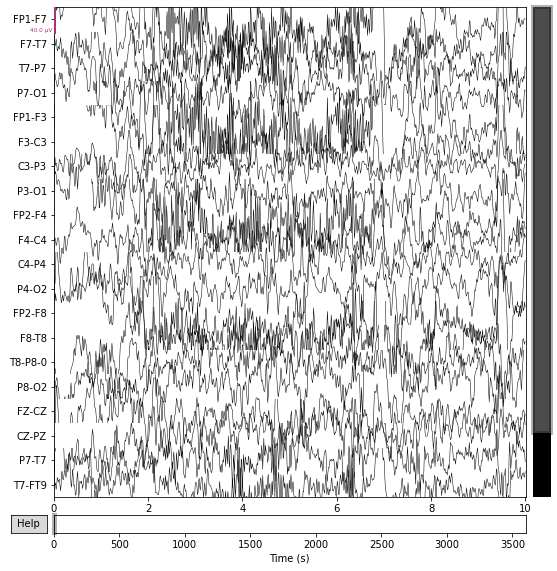

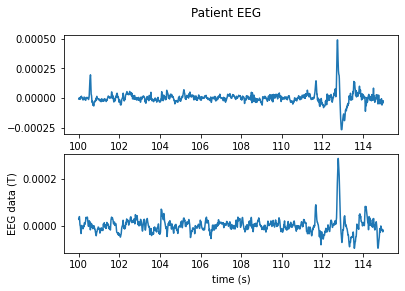

FileNotFoundError: ignored

In [15]:
seizures =	{
    "chb01_03":[[1467,1494]],
    "chb01_15": [[1732,1772]],
    "chb01_16": [[1015,1066]],
    "chb01_18": [[1720, 1810]],
    "chb01_21": [[327, 420]],
    "chb01_26": [[1862,1963]],

     "chb02_16": [[2972,3053]],
      "chb02_19": [[3369,3378]],

       "chb03_01": [[362,414]],
       "chb03_02": [[731,796]],
       "chb03_03": [[432,501]],
       "chb03_04": [[2162,2214]],
       "chb03_34": [[1982,2029]],
       "chb03_35": [[2952,2656]],
       "chb03_36": [[1725,1778]],

    "chb05_06": [[417, 532]], 
    "chb05_13": [[1086, 1196]],
    "chb05_16": [[2317, 2413]], 
    "chb05_17": [[2451, 2571]],
    "chb05_22": [[2348, 2465]],
    "chb08_02": [[2670, 2841]], 
    "chb08_05": [[2856, 3046]],
    "chb08_11": [[2988, 3211]], 
    "chb08_13": [[2417, 2577]],
    "chb08_21": [[2083, 2347]]
}
for filename in files:
    file = os.path.join(folder, filename)
    filename = os.path.splitext(filename)[0]
    res = eeg_preprocessing(file, seizures)
    res.to_csv(os.path.join('/content/drive/My Drive/data', filename + '.csv'), encoding='utf-8', index=False)
print("done")
